In [1]:
import oscovida

# The reproduction number R

In this notebook:

1. we describe some basics regarding the R value
2. Study how we can compute R from measured data of cases (or deaths) using two different methods
3. Apply these methods on different types of fake data with known values of R to recostruct these values.
4. Show how R is computed on the OSCOVIDA site

In [2]:
oscovida.display_binder_link('r-value.ipynb')

[Execute this notebook with Binder](https://mybinder.org/v2/gh/oscovida/binder/master?filepath=ipynb/r-value.ipynb)

# 1. Reproduction number R

## 1.1 Introduction


The [reproduction number (Wikipedia)](https://en.wikipedia.org/wiki/Basic_reproduction_number) can be thought of as the expected number of cases directly generated by one case in a population. 

In other words, if a person is infected, he will infect $R$ other people during the duration of his illness. If $n$ people are infected, they will affect $Rn$ people. These $Rn$ people will infect $RRn=R^2n$ people, etc. This leads to the exponential growth of the type $nR^s$ with $s$ being the number of periods over which one generation of infected people will infect the next.

One way to represent $R$ is $R = \beta \,\tau $ where $\beta$ represents an average infection-producing contacts per unit time and $\tau$ the infectious period. The infections period for COVID19 is often assumed to be 4 or 5 days.

For exponential growth with case numbers $n(t)$ increasing as 

\begin{equation}
n(t) = n(t_0) R^{t/\tau}, \tag{1}
\end{equation} 

the logarithmic growth rate $K$ can be used to describe the growth: 

\begin{equation}
K = \frac{\mathrm{d} \ln(n)}{\mathrm{d}t}. \tag{2}
\end{equation}

The relationship between $R$ and $K$ is 

\begin{equation}
R = \exp(K\tau) \tag{3} 
\end{equation}

or equivalently $K = \ln(R)/\tau$.

[1] [Basic reproduction number (Wikipedia)](https://en.wikipedia.org/wiki/Basic_reproduction_number)

## 1.2 Create data with perfect exponential growth 

In [3]:
# Setup svg rendering in notebook
%config InlineBackend.figure_formats = ['svg']
import numpy as np

In [4]:
n_points = 15         # 15 points (=days) in this data set
t = np.arange(0, n_points, 1)   
tdiff = np.arange(0.5, n_points - 1, 1)  # we need this later
N0 = 1                # infections on day 0
tau = 4               # average infectious time: 4 days
R = 2.1               # R - number of new infections per 
n = N0*(R**(t/tau))   # compute vector n with perfect exponential growth

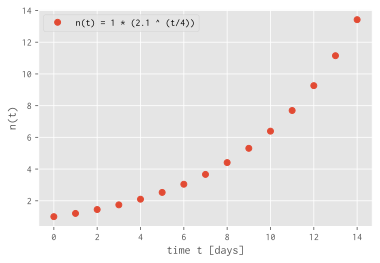

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(t, n, 'o', label=f'n(t) = {N0} * ({R} ^ (t/{tau}))')
ax.legend()
ax.set_xlabel("time t [days]");
ax.set_ylabel("n(t)");

## 1.3 Compute K and R from this synthetic data

In [6]:
ln_n = np.log(n)    
K = np.diff(ln_n)                 # equation (2)
R_reconstructed = np.exp(K*tau)   # equation (3)

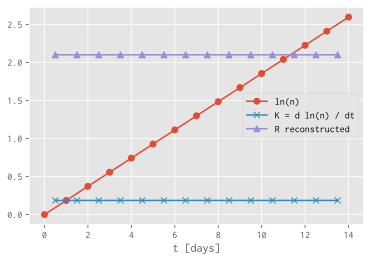

In [7]:
fig, ax = plt.subplots()
ax.plot(t, ln_n, 'o-', label='ln(n)')
ax.plot(tdiff, K, 'x-', label='K = d ln(n) / dt')
ax.plot(tdiff, R_reconstructed, '^-', label='R reconstructed')
ax.set_xlabel('t [days]')
ax.legend()

We expect that the reconstructed value `R_reconstructed` is the same as R when we computed the synthetic data for n(t):

In [8]:
R_reconstructed

array([2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1,
       2.1])

In [9]:
R

2.1

We turn this into an automatic test:

In [10]:
assert R_reconstructed[0] == R    # checks only first data point
                                  # where we have perfect agreement

In [11]:
R_reconstructed - R               # are all values of R_reconstructed
                                  # exactly identical to R?

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -4.44089210e-16,
        4.44089210e-16,  4.44089210e-16,  4.44089210e-16, -1.33226763e-15,
        4.44089210e-16,  4.44089210e-16,  4.44089210e-16,  4.44089210e-16,
       -3.10862447e-15,  4.44089210e-16])

The values are essentialy the same: deviations are of the order of $10^{-15}$. 

We compare all values but allow for some small deviation due to limited machine precision:

In [12]:
assert np.allclose(R_reconstructed, R)

## 1.4 Summary 

- We know the role of reproduction number $R$ in the exponential growth equation (1) 
- If we compute daily data points with exponential growth and grow rate $R$, we can use (2) to reconstruct $R$ from the data.
- This was just a little exercise to gain confidence with that equation.

The potentially harder question is: how do we compute $R$ from _measured_ data which does not show perfect exponential growth.


# 2. Compute R from measured data

## 2.1 Method 1: as used by Robert Koch Institute (RKI)

The bulletin from the Robert Koch institute [2] reports that an average infectious period of $\tau = 4$ days is assumed. Based on that information, the description of the method to compute $R$ (or $R_0$) is [3]

- compute an average $<n>_1$ of daily new infections over 4 days (say days 0 to 3)
- compute an average $<n>_2$ of daily new infections over 4 subsequent days (say days 4 to 7)
- compute the quotient $<n>_2 / <n>_1$ 

The method is references as being reported in [4].

[2] [Robert Koch Institute: Epidemiologisches Bulletin 17 | 2020 23. April 2020, page 13 onwards](https://www.rki.de/DE/Content/Infekt/EpidBull/Archiv/2020/Ausgaben/17_20.html)

[3] "_Bei einer konstanten Generationszeit von 4 Tagen, ergibt sich R als Quotient der Anzahl von Neuerkrankungen in zwei aufeinander folgenden Zeitabschnitten von jeweils 4 Tagen. Der so ermittelte R-Wert wird dem letzten dieser 8 Tage zugeordnet, weil erst dann die gesamte Information vorhanden ist._"

[4] Wallinga J, Lipsitch M: How generation intervals shape the relationship between growth rates and reproductive numbers. [Proceedings of the Royal Society B:
Biological Sciences 2007;274(1609):599–60](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1766383/)



## 2.2 Method 2: K from d log(n)/dt and tau

We can also try to use equations (2) and (3) on measured data to extract $R$, as shown in section 1.3 above.

# 3. Testing Method 1 and Method 2

## 3.1 Approach

To test method 1 and method 2, we will create different types of 'synthetic data' that does not show perfect exponential growth. Yet, we create it with a known (but potentially varying) $R$ values, and see how accurately the different methods can reconstruct these $R$ values from the data.

We test this here with the following types of data:
- Test A: perfect exponential growth (one $R$ value)
- Test B: exponential growth with (step) changes in $R$ over time
- Test C: adding noise to the data points

## 3.2 Test A: perfect exponential growth

## 3.2.1 Test A - method 1 (RKI)

In [13]:
import pandas as pd

In [14]:
s = pd.Series(n, index=t)    # turn numpy array into pandas Series

In [15]:
c = s.diff().dropna()        # compute the change from day to day 
                             # (i.e. dn/dt, time unit is one day
                             # and drop the first value for which can't compute dn/dt
                             # and for which the `diff` method has insert NaN

In [16]:
mean1 = c[0:4].mean()        # take mean over first 4 days
mean2 = c[4:8].mean()        # take mean over next 4 days

In [17]:
quotient = mean2 / mean1     # Compute R as quotient of the two means
quotient

2.1

In [18]:
assert quotient == R

Seems to be okay (for perfect exponential growth)

### 3.2.2 Test A - method 2: R from d log(n)/dt and tau


We can also try to use equations (2) and (3) on measured data to extract $R$. We have done this above already, but complete it here for completeness:

In [19]:
K = np.log(s).diff().dropna()
R_reconstructed2 = np.exp(K*tau)
R_reconstructed2

1     2.1
2     2.1
3     2.1
4     2.1
5     2.1
6     2.1
7     2.1
8     2.1
9     2.1
10    2.1
11    2.1
12    2.1
13    2.1
14    2.1
dtype: float64

In [20]:
assert np.allclose(R_reconstructed2.values[0], R)

This also works fine.

## 3.3 Test B: with time-dependent $R$ (step changes in $R$)

## Create fake data


First, we define a function `fake_growth` that can create test data which exhibits exponential growth of $n(t)$ for where the growth rate (that depends on $R$) can vary as a function of $t$:

In [21]:
def fake_growth(delta_t, Rs, tau: float, N0:int=1, debug:bool=False):
    """Expect 
    - delta_t: a vector with ints: each int indicates for how many days
         R should be constant
    - Rs: a vector with the corresponding values for R
    - tau: a constant for the assumption of the average infectious period
    - N0=1: number of initial cases (for t[0]=0)
    
    Assumes exponential growth according to
    N[i] = N0*(R**(t/tau)) from day i to day i+1 with rate R, where
    R is specified through delta_t and Rs.
        
    Compute and return a time series n. 
    
    Also return a vector of days t and a vector of values `Rvec` 
    that show which R values were used for which interval.
    
    Returns triplet (n, t, Rvec).
    
    """
    def f(R_, t_, tau, c):
        """Exponential growth """
        return c * R_**(t_/tau)
    
    # check assumptions
    assert len(delta_t) == len(Rs)

    # total number of days
    total_days = sum(delta_t) + 1 
    if debug:
        print(f"Looking at {total_days} days.")
    
    # create arrays
    t = np.arange(total_days)
    Rvec = np.zeros(shape=t.shape)
    #dN = np.zeros(shape=t.shape)
    n = np.zeros(shape=t.shape)   # final result of function

    #dN[0] = N0
    counter = 0
    n[counter] = N0

 
    counter += 1
    for dt, this_R in zip(delta_t, Rs):
        if debug:
            print (dt, this_R)
        for i in range(dt):
            n[counter] = f(this_R, i+1, tau, N0)
            assert t[counter] == counter 
            Rvec[counter - 1] = this_R
            counter += 1
        # take the last value as the starting point for next
        # sequence
        N0 = n[counter-1]

    # last point in Rvec is meaningless
    Rvec[counter-1] = np.nan
        
    # n has values for n(t), length total_days
    # t has values for n(t), length total_days
    # Rvec[0] has value for R that was valid from t[0] to t[1] and resulted in
    # value for n[1].
    # Rvec[1] has value for R that was valid from t[1] to t[1] and resulted in
    # value for n[2].
    # Rvec[-1] has np.nan 
        
    return n, t, Rvec
    

# Try a simple test set, where tau=1 and R is 2, 3, and 4, for 3 days, 2 days and 1 day, respectively
# Initial value is N0=1
n, t, Rvec = fake_growth([3, 2, 1], [2, 3, 4], tau=1, N0=1)

In [22]:
n

array([  1.,   2.,   4.,   8.,  24.,  72., 288.])

In [23]:
t

array([0, 1, 2, 3, 4, 5, 6])

In [24]:
Rvec

array([ 2.,  2.,  2.,  3.,  3.,  4., nan])

A function to test our implementation of the `fake_growth`:

In [25]:
def test_fake_growth():
    """ Assume constant growth rate, and expect exponential growth."""
    R_number = 2.1
    tau = 4.5
    N0 = 1.3
    n1, t, Rvec = fake_growth([5, 5, 2, 10], 4*[R_number], tau, N0)
    n2 = N0 * R_number ** (t / tau)   # correct result
    diff = n2 - n1                    # should be zero
    max_err = np.max(np.abs(diff))
    print(f"Max error is {max_err}")
    assert max_err < 1e-14
    return n1, n2

n1, n2 = test_fake_growth();

Max error is 7.105427357601002e-15


Let's create a plot of the fake data, so we better understand its characteristics:

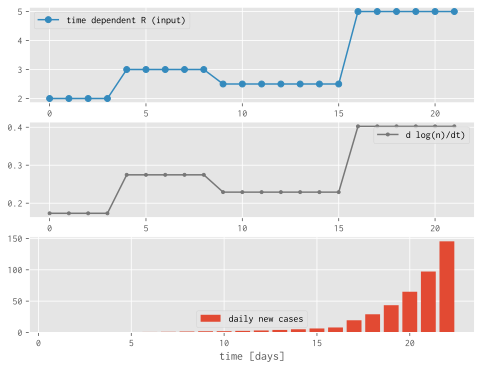

In [26]:
# change growth rate
n_fake, t, Rvec = fake_growth([4, 5, 7, 6], [2, 3, 2.5, 5], tau)

# smooth it
# n_fake = pd.Series(n_fake).rolling(7, center=True, 
#                        win_type='gaussian', 
#                        min_periods=7).mean(std=3)


import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,6))
ax1.plot(t, Rvec, '-o',color='C1', label="time dependent R (input)")
ax2.plot(t[:-1], np.diff(np.log(n_fake)), '.-', color='C3', label=f'd log(n)/dt)')
n_fake = pd.Series(n_fake)  # turn into pandas.Series to get diff() method
ax3.bar(t, n_fake.diff(), label='daily new cases')
ax3.set_xlabel('time [days]');
ax1.legend(),ax2.legend(), ax3.legend();


In [27]:
Rvec.shape

(23,)

In [28]:
n_fake.shape

(23,)

### Now we create some fake data that will be used to test the different methods of computing R from it.

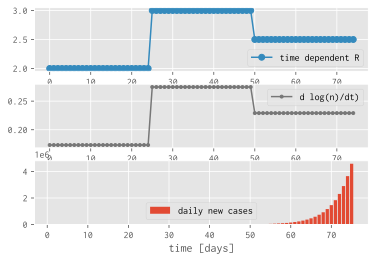

In [29]:
n_fake, t, Rvec = fake_growth([25, 25, 25], [2, 3, 2.5], tau=4, N0=1)


import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.plot(t, Rvec, '-o',color='C1', label="time dependent R")
ax2.plot(t[:-1], np.diff(np.log(n_fake)), '.-', color='C3', label=f'd log(n)/dt)')
n_fake = pd.Series(n_fake)  # turn into pandas.Series to get diff() method
ax3.bar(t, n_fake.diff(), label='daily new cases')
ax3.set_xlabel('time [days]');
ax1.legend(),ax2.legend(), ax3.legend();


Turn this data into a DataFrame for easier processing

In [30]:
df = pd.DataFrame({'R_td' : Rvec, 'n_td' : n_fake, 'c_td' : list(n_fake.diff()[1:]) + [np.nan]})

The column labels are:

- `R_td` : R Time Dependent (this is the input R that we want to reconstruct)
- `n_td` : the time-dependent cases (this is what would be reported from detected infections)
- `c_td` : change in `n_td` from day to day

In [31]:
df.head()

,R_td,n_td,c_td
0,2.0,1.000000,0.189207
1,2.0,1.189207,0.225006
2,2.0,1.414214,0.267579
3,2.0,1.681793,0.318207
4,2.0,2.000000,0.378414


In [32]:
df.tail()

,R_td,n_td,c_td
71,2.5,8.966653e+06,2.308316e+06
72,2.5,1.127497e+07,2.902554e+06
73,2.5,1.417752e+07,3.649768e+06
74,2.5,1.782729e+07,4.589341e+06
75,NaN,2.241663e+07,NaN


### 3.3.1 Test Method 1: RKI for time dependent $R$

In [33]:
# Smoothing makes things a lot better:
df['smooth_c'] = df['c_td'].rolling(7, center=True, 
                                    win_type='gaussian', 
                                    min_periods=7).mean(std=3)
# but important to have min_periods the same as the rolling period

# compute the mean over 4 days
df['mean4d'] = df['c_td'].rolling(4).mean()

# compute the time dependent R that  is reconstructed:
df['R_td-recon'] = df['mean4d'] / df['mean4d'].shift(4)


# show R_td (known) next to R_td-recon (reconstructed)
df[['R_td', 'R_td-recon', 'n_td', 'mean4d']].head(10)

,R_td,R_td-recon,n_td,mean4d
0,2.0,NaN,1.000000,NaN
1,2.0,NaN,1.189207,NaN
2,2.0,NaN,1.414214,NaN
3,2.0,NaN,1.681793,0.250000
4,2.0,NaN,2.000000,0.297302
5,2.0,NaN,2.378414,0.353553
6,2.0,NaN,2.828427,0.420448
7,2.0,2.0,3.363586,0.500000
8,2.0,2.0,4.000000,0.594604
9,2.0,2.0,4.756828,0.707107


In [34]:
df[['R_td', 'R_td-recon']].tail(n=5)

,R_td,R_td-recon
71,2.5,2.5
72,2.5,2.5
73,2.5,2.5
74,2.5,2.5
75,NaN,NaN


Plot the reconstructed $R$ (orange dots) next to the real $R$ (crosses on blue line)

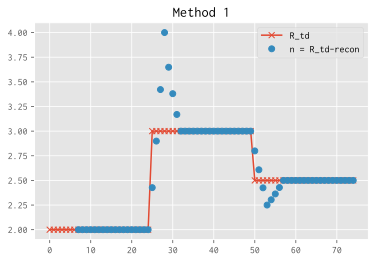

In [35]:
fig, ax = plt.subplots()
ax.plot(t, df['R_td'], '-x', label='R_td')
ax.plot(t, df['R_td-recon'], 'o', label=f'n = R_td-recon')
ax.legend()
ax.set_title('Method 1');

So the method works but there is some over shooting and undershooting when $R$ changes abruptly. 


### 3.3.2 Test Method 2: for time dependent $R$

In [36]:
df['K'] = np.log(df['n_td']).diff(periods=1).shift(-1)

df['R_td-recon2'] = np.exp(df['K'] * tau)


In [37]:
df[['R_td', 'R_td-recon2']].head()

,R_td,R_td-recon2
0,2.0,2.0
1,2.0,2.0
2,2.0,2.0
3,2.0,2.0
4,2.0,2.0


In [38]:
df[['R_td', 'R_td-recon2']].tail()

,R_td,R_td-recon2
71,2.5,2.5
72,2.5,2.5
73,2.5,2.5
74,2.5,2.5
75,NaN,NaN


Plot the reconstructed $R$ (green dots) next to the real $R$ (crosses on blue line)

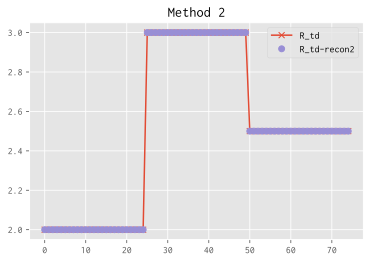

In [39]:
fig, ax = plt.subplots()
ax.plot(t, df['R_td'], '-x', label='R_td')
ax.plot(t, df['R_td-recon2'], 'o', color='C2', label=f'R_td-recon2')
ax.legend()
ax.set_title('Method 2');

This method reconstructs R very accurately (for this data set). No overshooting, in comparison to method 1.

## Compare Method 1 and Method 2 for time dependent $R$

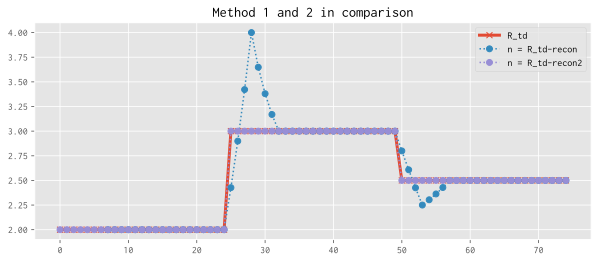

In [40]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(t, df['R_td'], '-x', linewidth=3, label='R_td')
ax.plot(t, df['R_td-recon'], 'o:', color="C1", label=f'n = R_td-recon')
ax.plot(t, df['R_td-recon2'], 'o:', color="C2", label=f'n = R_td-recon2')
ax.legend()
ax.set_title('Method 1 and 2 in comparison');
ax.grid('on')

## 3.3.3 Summary time dependent $R$

Both methods recover the right value of $R$ after a period of approximately $\tau$ (which is 4 days here). Method 1 overshoots and undershoots following sudden changes of $R$.

## 3.4 Test 2: data with random noise

In reality, not only does the R value change through change in behaviour, we also have an incomplete and noisy measurement. Here we try to add some noise and reconstruct $R$ from the data despite the noise.

In [41]:
N0 = 3
tau = 4
n_fake, t, Rvec = fake_growth([50], [2.0], tau)

noise = np.random.uniform(size=t.shape) - 0.5
# add 10% noise (relative error to actual signal)
n_fake = pd.Series(n_fake * (1 + 0.5 * noise))

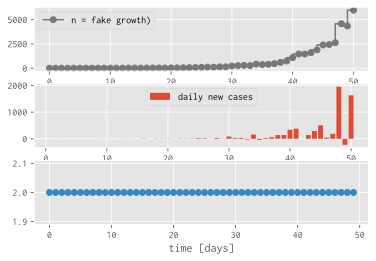

In [42]:

fig, (ax, ax2, ax3) = plt.subplots(3, 1)
ax.step(t, n_fake, 'o-', color='C3', label=f'n = fake growth)')
ax3.plot(t, Rvec, '-o',color='C1', label="time dependent R0")
ax2.bar(t, n_fake.diff(), label='daily new cases')

ax3.set_xlabel('time [days]');
ax.legend(), 
ax2.legend()

In [43]:
df = pd.DataFrame({'R_td' : Rvec[0:-1], 'n_td' : n_fake[:-1], 'c_td' : n_fake.diff()[:-1]})

In [44]:
df.head()

,R_td,n_td,c_td
0,2.0,1.003612,NaN
1,2.0,1.030991,0.027379
2,2.0,1.687472,0.656482
3,2.0,1.944292,0.256819
4,2.0,1.939042,-0.005250


In [45]:
df.tail()

,R_td,n_td,c_td
45,2.0,2393.572268,506.392034
46,2.0,2437.310747,43.738478
47,2.0,2622.880655,185.569908
48,2.0,4576.795273,1953.914618
49,2.0,4349.169241,-227.626032


### 3.4.1 Test Method 1 on random noise

In [46]:
df['mean4d'] = df['c_td'].rolling(4).mean()
df['R_td-recon'] = df['mean4d'] / df['mean4d'].shift(4)

df[['R_td', 'R_td-recon', 'n_td', 'mean4d']].head(n=20)

,R_td,R_td-recon,n_td,mean4d
0,2.0,NaN,1.003612,NaN
1,2.0,NaN,1.030991,NaN
2,2.0,NaN,1.687472,NaN
3,2.0,NaN,1.944292,NaN
4,2.0,NaN,1.939042,0.233857
5,2.0,NaN,2.512571,0.370395
6,2.0,NaN,2.842343,0.288718
7,2.0,NaN,3.376758,0.358116
8,2.0,1.839406,3.659678,0.430159
9,2.0,1.856644,5.263338,0.687692


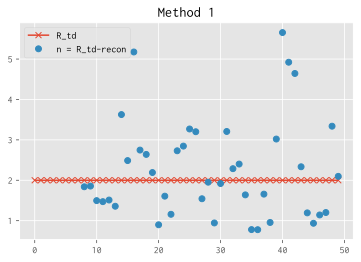

In [47]:
fig, ax = plt.subplots()
ax.plot(t[0:-1], df['R_td'], '-x', label='R_td')
ax.plot(t[0:-1], df['R_td-recon'], 'o', label=f'n = R_td-recon')
ax.legend()
ax.set_title('Method 1');

The noise seems amplified in the reconstructed R.

#### Let's try some smoothing of the noisy data:

In [48]:

df['smooth_c'] = df['c_td'].rolling(7, center=True, 
                                    win_type='gaussian', min_periods=7).mean(std=3)
df['mean4d'] = df['smooth_c'].rolling(4).mean()


df['R_td-recon'] = df['mean4d'] / df['mean4d'].shift(4)

df[['R_td', 'R_td-recon', 'n_td', 'mean4d']].head(n=20)

,R_td,R_td-recon,n_td,mean4d
0,2.0,NaN,1.003612,NaN
1,2.0,NaN,1.030991,NaN
2,2.0,NaN,1.687472,NaN
3,2.0,NaN,1.944292,NaN
4,2.0,NaN,1.939042,NaN
5,2.0,NaN,2.512571,NaN
6,2.0,NaN,2.842343,NaN
7,2.0,NaN,3.376758,0.401176
8,2.0,NaN,3.659678,0.445248
9,2.0,NaN,5.263338,0.487391


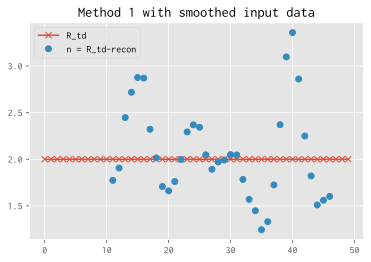

In [49]:
fig, ax = plt.subplots()
ax.plot(t[:-1], df['R_td'], '-x', label='R_td')
ax.plot(t[:-1], df['R_td-recon'], 'o', label=f'n = R_td-recon')
ax.legend()
ax.set_title('Method 1 with smoothed input data');

While the reconstructed $R$ values are not exactly 2.0, they now range between ~1.4 and 2.5; so less than about 25% relative error (that's after smoothing the data).

### 3.4.2 Method 2 for data with random noise

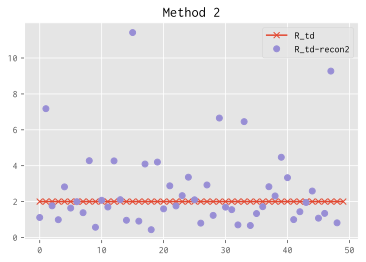

In [50]:
df['K'] = np.log(df['n_td']).diff(periods=1).shift(-1)
df['R_td-recon2'] = np.exp(df['K'] * tau)


fig, ax = plt.subplots()
ax.plot(t[:-1], df['R_td'], '-x', label='R_td')
ax.plot(t[:-1], df['R_td-recon2'], 'o', color='C2', label=f'R_td-recon2')
ax.legend()
ax.set_title('Method 2');



#### Method 2 with smooting

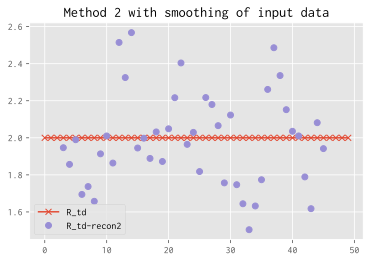

In [51]:
df['smooth_n'] = df['n_td'].rolling(7, center=True, 
                                    win_type='gaussian', min_periods=7).mean(std=3)
df['K'] = np.log(df['smooth_n']).diff(periods=1).shift(-1)
df['R_td-recon2'] = np.exp(df['K'] * tau)


fig, ax = plt.subplots()
ax.plot(t[:-1], df['R_td'], '-x', label='R_td')
ax.plot(t[:-1], df['R_td-recon2'], 'o', color='C2', label=f'R_td-recon2')
ax.legend()
ax.set_title('Method 2 with smoothing of input data');


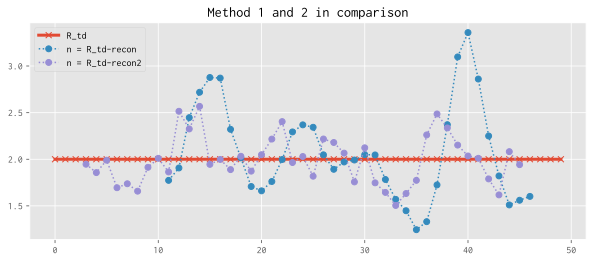

In [52]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(t[:-1], df['R_td'], '-x', linewidth=3, label='R_td')
ax.plot(t[:-1], df['R_td-recon'], 'o:', color="C1", label=f'n = R_td-recon')
ax.plot(t[:-1], df['R_td-recon2'], 'o:', color="C2", label=f'n = R_td-recon2')
ax.legend()
ax.set_title('Method 1 and 2 in comparison');
ax.grid('on')

## 3.4.3 Summary

Method 1 and 2 perform similarly for data with random noise. Smoothing of the input data is important.

## Conclusions

- Reconstruction of R from perfect exponential growth works using both methods.

- Reconstruction of R from exponential growth with sudden rate changes works well for method 2. 
  For method 1, the algorithm seems stable, and returns the correct value R (after ~tau days) if R is constant
  but based on the test data used here is less accurate than method 2.

- Use smoothing for the case numbers (or the diff of the case numbers) seems to improve estimates, and is important 
  (in particular to deal with noise in the data).

- It is important for the rolling averages (both for the smoothing of the diff, and for the
  4-day average) to use all data points, and not to ignore some. If we use 'min_values=' to allow fewer 
  data points, the reconstructed R values show systematic errors at the beginning and end of the interval. 
  (This is not show above but has been explored separately.)

- For now, we use Method 1 in the computation of R on the [OSCOVIDA site](https://oscovida.github.io). 
  The relevant source code is in 
  [the file oscovida.py](https://github.com/oscovida/oscovida/blob/master/oscovida/oscovida.py#L866) in the function `plot_reproduction_number`, which in turn calls `compute_R`.

  - This is for historical reasons and a lack of time for more systematic testing of method 2.
  - using method 2, we may also get rid of the lag of $\tau$ days in the computation of R

# 4. Demo: compute R with OSCOVIDA

In [53]:
import oscovida

In [54]:
cases, deaths, label = oscovida.get_country_data("Germany")


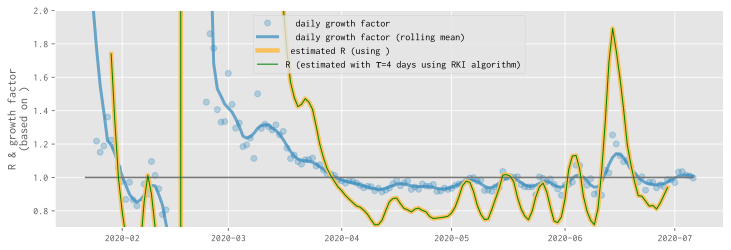

In [55]:

fig, ax = plt.subplots(1, 1 , figsize=(12, 4))
# change, smooth, smooth2 = oscovida.compute_daily_change(cases)
oscovida.plot_reproduction_number(ax, cases, "C1")

# Compare with more manual calculation

# compute change from day to day
diff = cases.diff()
# smooth that change
smooth_diff = diff.rolling(7, center=True, win_type='gaussian').mean(std=4)
# Compute R using method 1
R = oscovida.compute_R(smooth_diff, tau=4)

# plot as thin green line
ax.plot(R.index, R, "g", label=r"R (estimated with $\tau$=4 days using RKI algorithm)", linewidth=1)

ax.legend()
ax.set_ylim([0.7, 2]);



The computation of R is done in the overview plots. See https://oscovida.github.io/plots.html for more details:

Germany cases


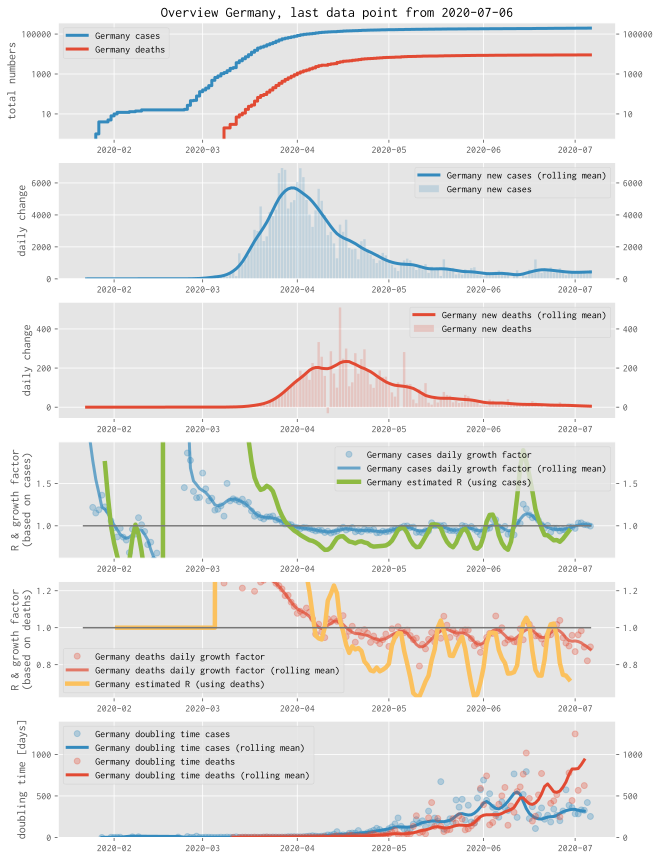

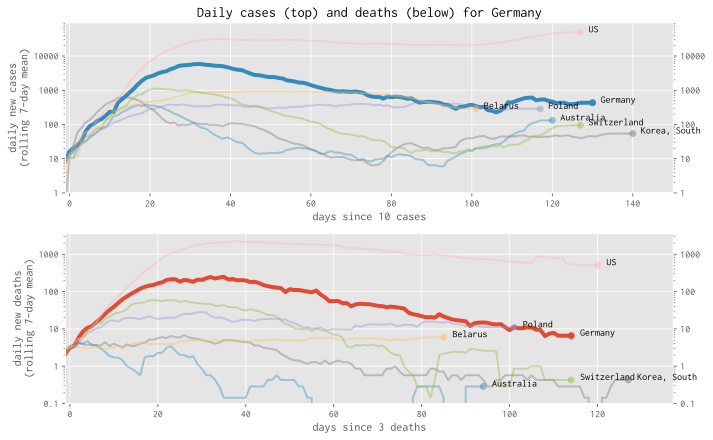

In [56]:
oscovida.overview("Germany");

# Outlook

Should we try to use Method 2 to compute R?